필요한 패키지를 가져옵니다.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import urllib

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.datasets import fashion_mnist

패션아이템 이미지 데이터셋을 불러옵니다. 

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

print('x_train shape : ' + str(x_train.shape))
print('y_train shape : ' + str(y_train.shape))
print('x_test shape : ' + str(x_test.shape))
print('y_test shape : ' + str(y_test.shape))

4431872/4422102 [==============================] - 0s 0us/step
x_train shape : (60000, 28, 28)
y_train shape : (60000,)
x_test shape : (10000, 28, 28)
y_test shape : (10000,)


테스트할 샘플 하나를 살펴봅니다.

인공지능 모델이 이 이미지를 입력받았을 때, 해당하는 숫자를 출력할 수 있도록 만드는 것이 목표입니다. 우리는 y_test 라벨값도 가지고 있어서 바로 확인은 할 수 있으나, 모델 학습 시에는 사용이 되지 않으며, 시험 평가할 때만 사용됩니다.

In [ ]:
print(y_test[0])

9


패션아이템 이미지와 라벨의 숫자가 의미하는 아이템 이름과 함께 같이 가시화 시킵니다.

모델 학습에 용이하도록 다음과 같이 데이터 전처리를 수행합니다.

*   데이터 전처리
    * 3차원(샘플수, 세로, 가로)를 2차원(샘플수, 벡터수)으로 변경
    * 정수를 실수로 변경
    * 0 ~ 255 사이의 수치를 0.0 ~ 1.0 사이로 정규화 수행
*   라벨 전처리
    * 0 ~ 9 라벨에 대한 원핫인코딩 수행 



In [ ]:
from scipy import ndimage
def data_augmentation(images, labels): # agumentation된 이미지랑 label을 저장할 빈 리스트 생성 
  aug_images = [] 
  aug_labels = [] 
  for x, y in zip(images, labels): 
    aug_images.append(x) # 리스트에 먼저 오리지널 이미지와 레이블을 저장 
    aug_labels.append(y) 
    bg_value = np.median(x) 
    # rotation이나 shift 후 생기는 이미지의 빈 공간을 채우기 위한 back ground value값 설정 
    # for문을 4번돌려 데이터를 4배로 불림 
    # 오리지널 데이터를 한 번 저장하고 여기서 4배의 데이터를 만들어내므로 총 5배의 데이터로 증가한다. 
    for _ in range(4):
      angle = np.random.randint(-15, 15, 1) # -15~15사이의 랜덤한 수를 뽑아서 그 각도로 rotation 
      rot_img = ndimage.rotate(x, angle[0], reshape=False, cval=bg_value) # cval옵션으로 빈공간을 채움 
      # 앞서 rotation시킨 데이터를 다시 shift시킴 
      shift = np.random.randint(-2, 2, 2) # -2px~2px사이의 값으로 shift, 숫자를 2개를 뽑아서 하나는 가로 방향, 하나는 세로 방향에 적용 
      shift_img = ndimage.shift(rot_img, shift, cval=bg_value) # rotation, shift 적용된 이미지를 리스트에 저장 
      aug_images.append(shift_img) 
      aug_labels.append(y) # 불린 데이터를 저장한 리스트를 np.array형태로 변환하여 리턴 
  aug_images = np.array(aug_images) 
  aug_labels = np.array(aug_labels) 
  return aug_images, aug_labels

x_train, y_train = data_augmentation(x_train, y_train)


x_train = x_train.reshape(-1, 784).astype('float32') / 255.0
x_test = x_test.reshape(10000, 784).astype('float32') / 255.0
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
(x_train11, y_train11), (x_test11, y_test) = fashion_mnist.load_data()
y_test = to_categorical(y_test)

모델은 다음과 같이 구성하였습니다.

* 입력: 1차원의 784개 벡터
* 출력: 10개 벡터
* 출력층의 활성화 함수: 소프트맥스
* 손실함수: categorical_crossentropy
* 최적화기: adam
* 평가 메트릭: accuracy

컨볼루션 신경망을 구성하기 위해, 컨볼루션 레이어, 맥스풀링 레이어, 플래튼 레이어를 사용하였습니다.


In [ ]:
x_train = x_train.reshape((-1,28, 28, 1))

In [ ]:
x_train.shape

(300000, 28, 28, 1)

In [ ]:
y_test = x_test.reshape((-1,28, 28, 1))

In [ ]:
from keras.layers import Conv2D, Activation, BatchNormalization, MaxPooling2D, Dropout, Input
import keras
model = Sequential()
model.add(Input(shape=(28, 28, 1)))
model.add(Conv2D(filters = 50, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters = 50, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
# 1x1 convolution
model.add(Conv2D(filters = 25, kernel_size = (1,1), strides = (1,1), padding = 'valid', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(filters = 50, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
# 1x1 convolution
model.add(Conv2D(filters = 25, kernel_size = (1,1), strides = (1,1), padding = 'valid', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters = 50, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
# 1x1 convolution
model.add(Conv2D(filters = 25, kernel_size = (1,1), strides = (1,1), padding = 'valid', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(filters = 50, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
# 1x1 convolution
model.add(Conv2D(filters = 25, kernel_size = (1,1), strides = (1,1), padding = 'valid', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters = 50, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
# 1x1 convolution
model.add(Conv2D(filters = 25, kernel_size = (1,1), strides = (1,1), padding = 'valid', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

# prior layer should be flattend to be connected to dense layers
model.add(Flatten())
# dense layer with 50 neurons
model.add(Dense(50, activation = 'relu', kernel_initializer='he_normal'))
model.add(Dropout(0.5))
# final layer with 10 neurons to classify the instances
model.add(Dense(10, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

모델 네트워크 아키텍처 구성을 그려보겠습니다.

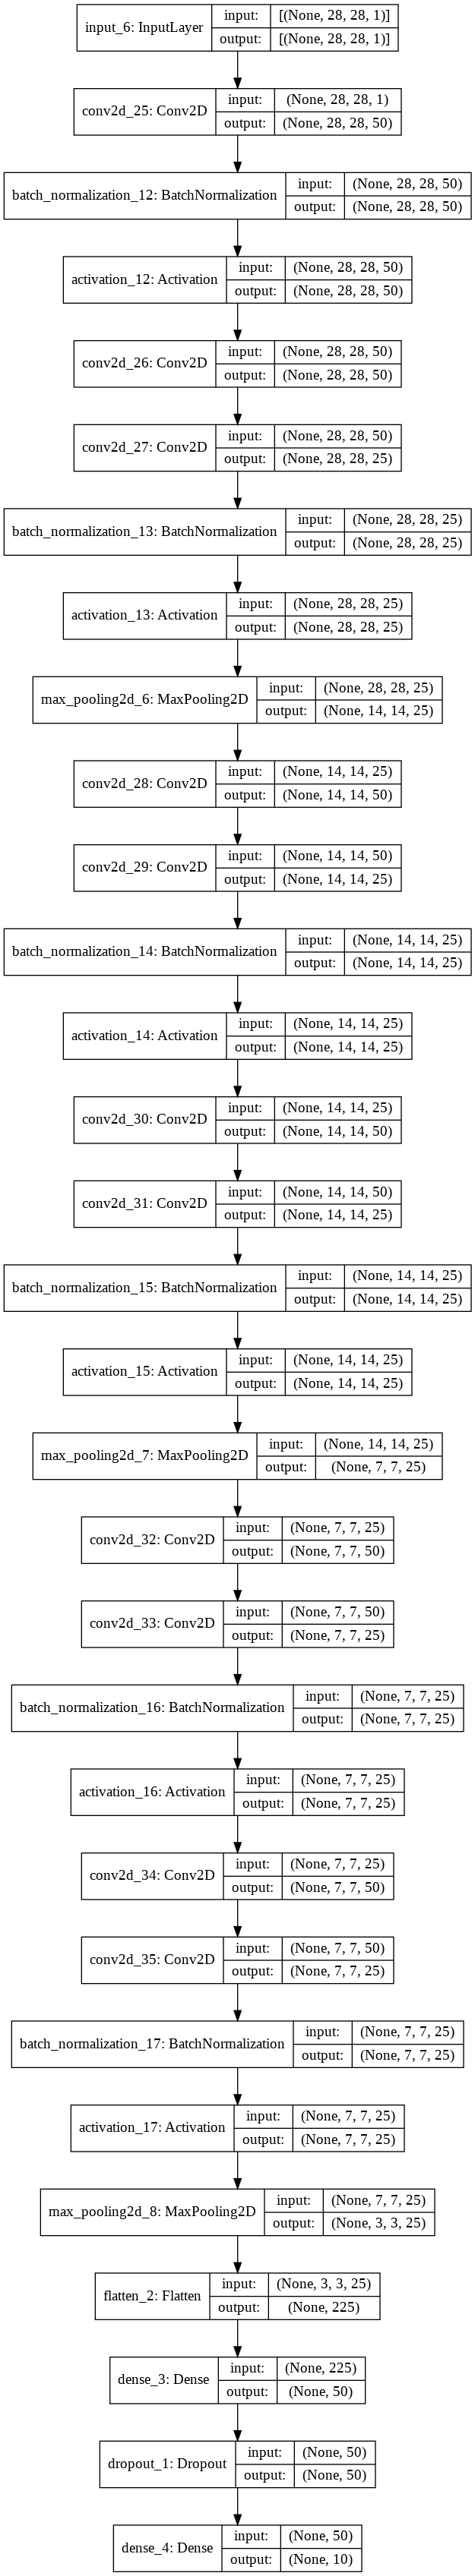

In [ ]:
plot_model(model, show_shapes=True)

모델을 학습시킬 때, validation_split 옵션을 두면 훈련셋 일부를 검증셋으로 설정할 수 있습니다. 0.2로 설정할 경우, 전체 훈련셋에서 20%를 검증셋, 나머지를 훈련셋으로 구성하여 학습합니다.

콜백함수를 사용하여, 매 에포크마다 검증셋의 손실값을 체크한 후, 이전 손실값보다 낮은 경우 모델을 파일로 저장합니다. 즉 학습 종료가 되면, "best_model.h5" 파일에 저장된 모델은 손실값이 가장 낮을 때의 가중치를 가지고 있습니다.

In [ ]:
checkpoint_callback = ModelCheckpoint("best_model.h5", 
                                      save_best_only=True, 
                                      monitor="val_loss")

hist = model.fit(x_train, y_train, 
                 validation_split=0.2, 
                 batch_size=128,
                 epochs=100,  
                 callbacks=[checkpoint_callback])

Epoch 1/100
1875/1875 [==============================] - 41s 13ms/step - loss: 0.6069 - accuracy: 0.7847 - val_loss: 0.3841 - val_accuracy: 0.8610
Epoch 2/100
1875/1875 [==============================] - 24s 13ms/step - loss: 0.3838 - accuracy: 0.8652 - val_loss: 0.3217 - val_accuracy: 0.8802
Epoch 3/100
1875/1875 [==============================] - 24s 13ms/step - loss: 0.3351 - accuracy: 0.8831 - val_loss: 0.2900 - val_accuracy: 0.8960
Epoch 4/100
1875/1875 [==============================] - 24s 13ms/step - loss: 0.3045 - accuracy: 0.8944 - val_loss: 0.2844 - val_accuracy: 0.8992
Epoch 5/100
1875/1875 [==============================] - 24s 13ms/step - loss: 0.2849 - accuracy: 0.9004 - val_loss: 0.2644 - val_accuracy: 0.9051
Epoch 6/100
1875/1875 [==============================] - 24s 13ms/step - loss: 0.2709 - accuracy: 0.9056 - val_loss: 0.2879 - val_accuracy: 0.9000
Epoch 7/100
1875/1875 [==============================] - 24s 13ms/step - loss: 0.2583 - accuracy: 0.9093 - val_loss: 0

학습 시 매 에포크에 해당하는 훈련셋과 검증셋에 대한 손실값과 평가 메트릭 수치를 확인할 수 있습니다. 이를 시각화시키면 어느 에포크에서 오버피팅이 일어났는 지 한 눈에 확인할 수 있습니다.

파일로 저장된 모델을 로딩하여 시험셋으로 최종 평가를 수행합니다.

In [ ]:
x_test1 = x_test.reshape((-1,28, 28, 1))

In [ ]:
x_test1.shape

(10000, 28, 28, 1)

In [ ]:
y_test.shape

(10000, 28, 28, 1)

In [ ]:
# model = load_model("best_model.h5")
test_loss, test_acc = model.evaluate(x_test1, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

313/313 [==============================] - 1s 4ms/step - loss: 0.3272 - accuracy: 0.9262
Test accuracy 0.9261999726295471
Test loss 0.32716166973114014


또한 시험셋으로 테스트한 결과를 제출하기 위해 모델 결과 파일을 저장합니다. 출력이 10개 클래스에 해당하는 벡터이므로, 분류한 클래스 정보를 얻기 위해 가장 높은 값을 가진 인덱스 값을 가지고 옵니다. 이 인덱스가 클래스를 의미하며, 이 값을 파일로 저장합니다.

In [ ]:
y_pred = model.predict(x_test1)
y_pred = y_pred.argmax(axis=-1)
np.savetxt('y_pred_cnn_ + '+ str(test_acc) +'.csv', y_pred, fmt='%d')

#### 실제로 사용해보기



In [ ]:
def download_real_image(filename):
    url = 'https://github.com/aifactory-team/AFClass/blob/master/aifactory/warehouse/' + filename + '?raw=true' 
    urllib.request.urlretrieve(url, filename)

def predict_from_real_image(filename, invert):
    
    f, axarr = plt.subplots(2,2, subplot_kw={'xticks': [], 'yticks': []})
    
    img = Image.open(filename)
    axarr[0,0].imshow(img)
    axarr[0,0].set_title('orgin')

    img = img.resize((28, 28), Image.LANCZOS)
    axarr[0,1].imshow(img)
    axarr[0,1].set_title('resize')

    img = img.convert('L')
    axarr[1,0].imshow(img, cmap='gray')
    axarr[1,0].set_title('gray')

    img = np.array(img)
    if invert == True:
        img = 255.0 - img
        axarr[1,1].set_title('invert')
    else:
        axarr[1,1].set_title('no invert')
        
    axarr[1,1].imshow(img, cmap='gray')

    x_predict = img.reshape(1, 28, 28, 1).astype('float32') / 255.0
    y_predict = model.predict(x_predict)
    print(y_predict)
    print(labels[np.argmax(y_predict, axis=1)[0]])

[[1.92582243e-04 8.36736945e-06 1.08890570e-04 2.08216043e-05
  1.17513184e-04 3.83580345e-06 2.39116998e-04 5.77956125e-05
  9.99243736e-01 7.33068327e-06]]
Bag


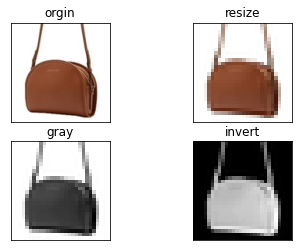

In [ ]:
download_real_image('fashion_item_1.png')
predict_from_real_image('fashion_item_1.png', invert = True)    

[[7.4732904e-03 1.7133568e-04 1.9420192e-04 4.3542706e-05 4.6669262e-05
  1.6586116e-04 2.4961848e-03 3.7308838e-04 9.8856419e-01 4.7157975e-04]]
Bag


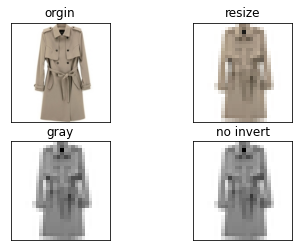

In [ ]:
download_real_image('fashion_item_2.png')
predict_from_real_image('fashion_item_2.png', invert=False) 

[[4.6384092e-03 4.0850675e-05 5.8623943e-03 8.9210339e-02 8.7955004e-01
  2.2546246e-05 2.0005936e-02 1.9660873e-05 6.1776431e-04 3.2147462e-05]]
Coat


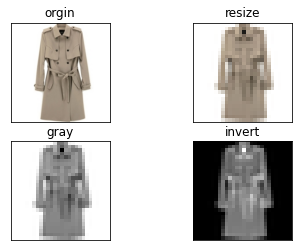

In [ ]:
download_real_image('fashion_item_2.png')
predict_from_real_image('fashion_item_2.png', invert=True) 

[[7.0755698e-02 2.5352836e-04 1.5924191e-03 7.0787421e-03 1.5602591e-04
  2.7521642e-02 2.6573159e-03 1.2243092e-01 7.6304591e-01 4.5077833e-03]]
Bag


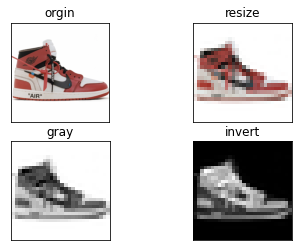

In [ ]:
download_real_image('fashion_item_3.png')
predict_from_real_image('fashion_item_3.png', invert=True) 

[[1.8431845e-05 5.3172425e-06 2.5848738e-06 1.7552700e-05 7.5333278e-06
  3.2379819e-05 2.0721118e-06 9.9053067e-01 2.6530556e-06 9.3807671e-03]]
Sneaker


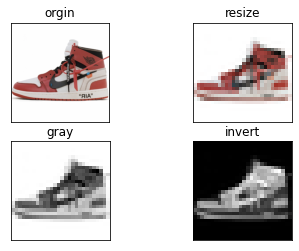

In [ ]:
download_real_image('fashion_item_4.png')
predict_from_real_image('fashion_item_4.png', invert=True) 